In [1]:
import pandas as pd
import numpy as np
import ipaddress

In [2]:
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

In [3]:
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

## Basic cleaning

In [5]:
df.drop_duplicates(inplace=True)
df['creation_time'] = pd.to_datetime(df['creation_time'], utc=True)
df['end_time'] = pd.to_datetime(df['end_time'], utc=True)
df['time'] = pd.to_datetime(df['time'], utc=True)

In [6]:
df = df.convert_dtypes()

## validate IPs

In [7]:
def is_valid_ip(ip):
    try:
        ipaddress.ip_address(ip)
        return True
    except:
        return False

In [8]:
# Remove rows with invalid IPs
df = df[df['src_ip'].apply(is_valid_ip) & df['dst_ip'].apply(is_valid_ip)]

In [9]:
# Show missing values & Drop rows where critical identifiers are missing
df_nulls = df.isnull().sum()
df.dropna(subset=['src_ip', 'dst_ip', 'creation_time', 'end_time'], inplace=True)

In [10]:
for col in ['bytes_in', 'bytes_out']:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

In [11]:
if 'src_ip_country_code' in df.columns:
    df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()
if 'protocol' in df.columns:
    df['protocol'] = df['protocol'].str.strip().str.upper()

# Feature Engineering

In [12]:
df['session_duration_mins'] = (df['end_time'] - df['creation_time']).dt.total_seconds() / 60

In [13]:
# log transformations
df['log_bytes_in'] = np.log1p(df['bytes_in'])
df['log_bytes_out'] = np.log1p(df['bytes_out'])

In [14]:
# Port classification
def categorize_port(port):
    if port in [80, 443]:
        return 'standard'
    elif port < 1024:
        return 'well_known'
    elif port < 49152:
        return 'registered'
    else:
        return 'dynamic'
if 'dst_port' in df.columns:
    df['port_type'] = df['dst_port'].apply(categorize_port)

In [15]:
df['is_standard_port'] = df['dst_port'].apply(lambda x: 1 if x in [80, 443] else 0)

In [16]:
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,observation_name,source.meta,source.name,time,detection_types,session_duration_mins,log_bytes_in,log_bytes_out,port_type,is_standard_port
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,10.0,8.631057,9.472012,standard,1
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,10.0,10.338932,9.808462,standard,1
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,10.0,10.257905,9.508146,standard,1
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,10.0,10.327022,9.566545,standard,1
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,10.0,8.783703,9.53914,standard,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 0 to 281
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   bytes_in               282 non-null    Int64              
 1   bytes_out              282 non-null    Int64              
 2   creation_time          282 non-null    datetime64[ns, UTC]
 3   end_time               282 non-null    datetime64[ns, UTC]
 4   src_ip                 282 non-null    string             
 5   src_ip_country_code    282 non-null    string             
 6   protocol               282 non-null    string             
 7   response.code          282 non-null    Int64              
 8   dst_port               282 non-null    Int64              
 9   dst_ip                 282 non-null    string             
 10  rule_names             282 non-null    string             
 11  observation_name       282 non-null    string             

# Exploratory Data Analysis (EDA) and Visualization

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
print("Descriptive Statistics:\n")
print(df.describe(include='all'))

Descriptive Statistics:

              bytes_in      bytes_out              creation_time  \
count            282.0          282.0                        282   
unique            <NA>           <NA>                         30   
top               <NA>           <NA>  2024-04-26 09:00:00+00:00   
freq              <NA>           <NA>                         17   
first             <NA>           <NA>  2024-04-25 23:00:00+00:00   
last              <NA>           <NA>  2024-04-26 09:50:00+00:00   
mean    1199390.191489    84554.29078                        NaN   
std     4149311.993487  254927.899195                        NaN   
min               40.0           44.0                        NaN   
25%             5381.5        11142.0                        NaN   
50%            13182.0        13799.5                        NaN   
75%            30833.0        26279.5                        NaN   
max         25207794.0      1561220.0                        NaN   

                      

C:\Users\ar446\AppData\Local\Temp\ipykernel_20912\3974656322.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(include='all'))
C:\Users\ar446\AppData\Local\Temp\ipykernel_20912\3974656322.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(include='all'))
C:\Users\ar446\AppData\Local\Temp\ipykernel_20912\3974656322.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future 

## Distribution Plots

### Bytes In/Out Distribution

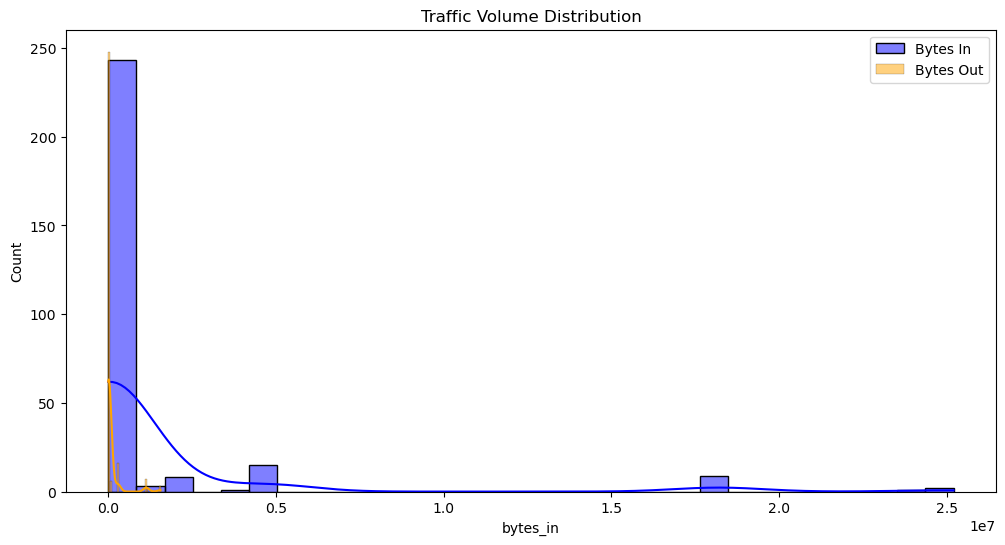

In [27]:
plt.figure(figsize=(12, 6))
bytes_in = pd.to_numeric(df['bytes_in'], errors='coerce').dropna().astype(float)
bytes_out = pd.to_numeric(df['bytes_out'], errors='coerce').dropna().astype(float)
sns.histplot(bytes_in, kde=True, label='Bytes In', color='blue', bins=30)
sns.histplot(bytes_out, kde=True, label='Bytes Out', color='orange', bins=30)
plt.title("Traffic Volume Distribution")
plt.legend()
plt.show()

### Log-Transformed Bytes

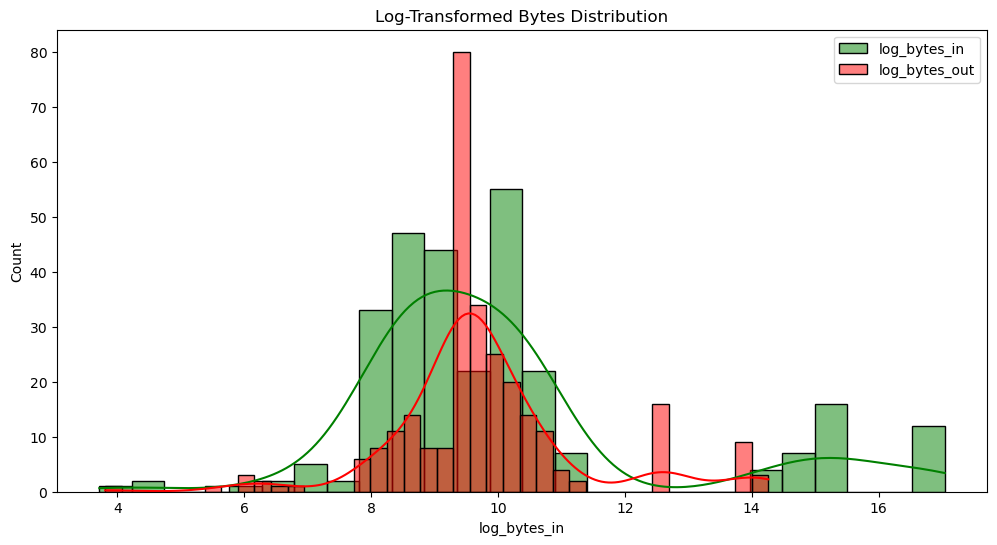

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(df['log_bytes_in'].dropna().astype(float), kde=True, color='green', label='log_bytes_in')
sns.histplot(df['log_bytes_out'].dropna().astype(float), kde=True, color='red', label='log_bytes_out')
plt.title("Log-Transformed Bytes Distribution")
plt.legend()
plt.show()

### Session Duration

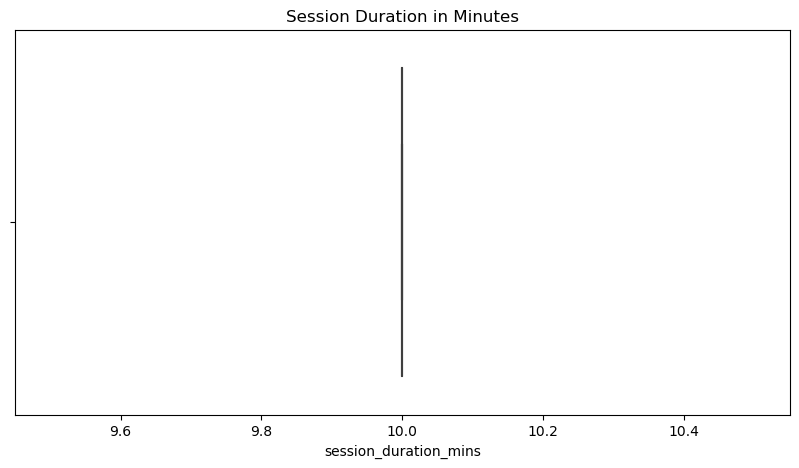

In [48]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='session_duration_mins')
plt.title("Session Duration in Minutes")
plt.show()

### Protocol Usage 

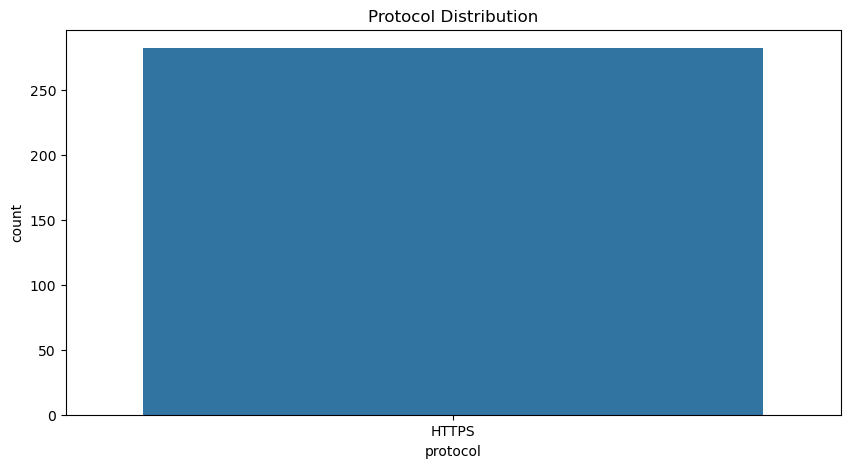

In [52]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='protocol', order=df['protocol'].value_counts().index)
plt.title("Protocol Distribution")
plt.xticks(rotation=0)
plt.show()

### Source Country Activity

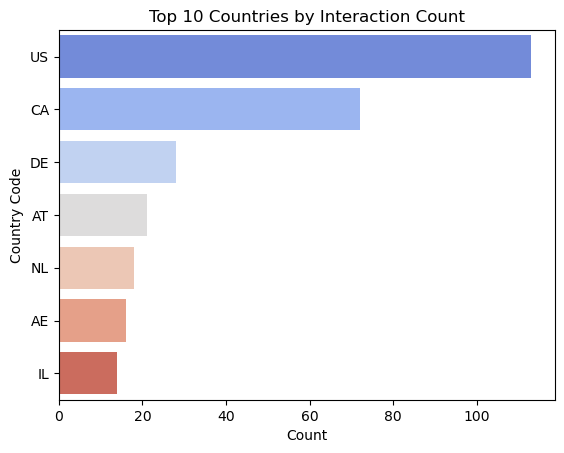

In [55]:
top_countries = df['src_ip_country_code'].value_counts().nlargest(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')
plt.title("Top 10 Countries by Interaction Count")
plt.xlabel("Count")
plt.ylabel("Country Code")
plt.show()

### Correlation Matrix

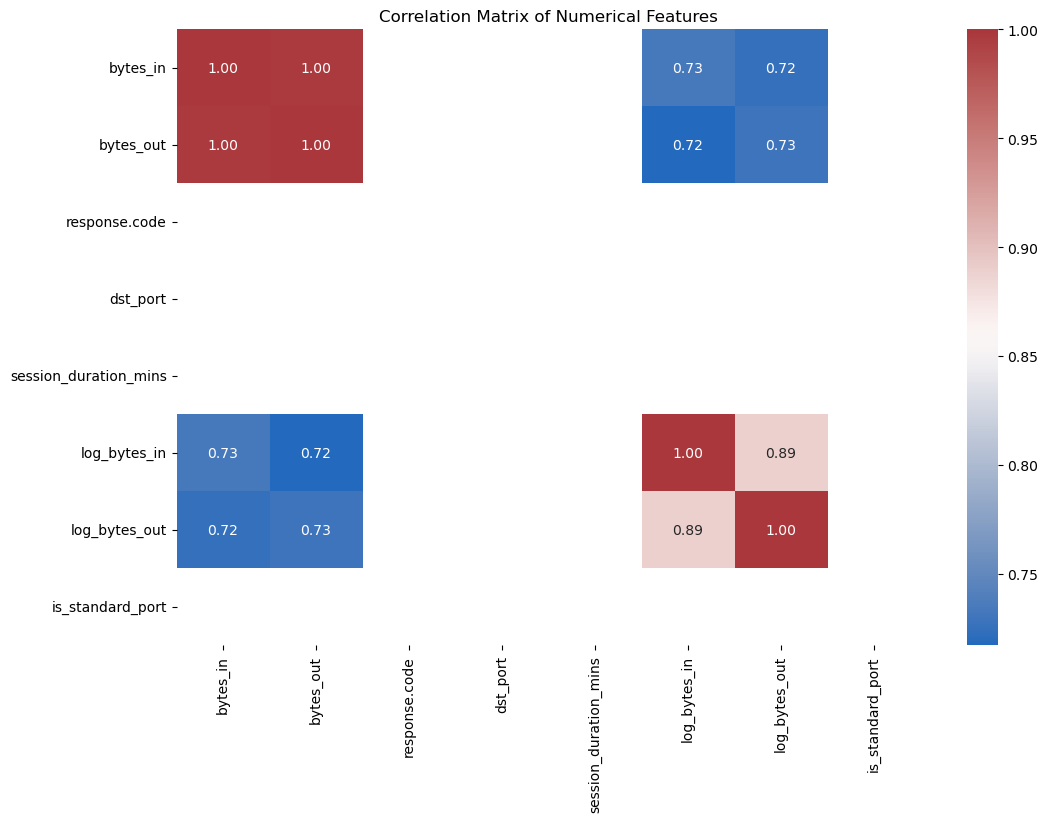

In [61]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='vlag')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

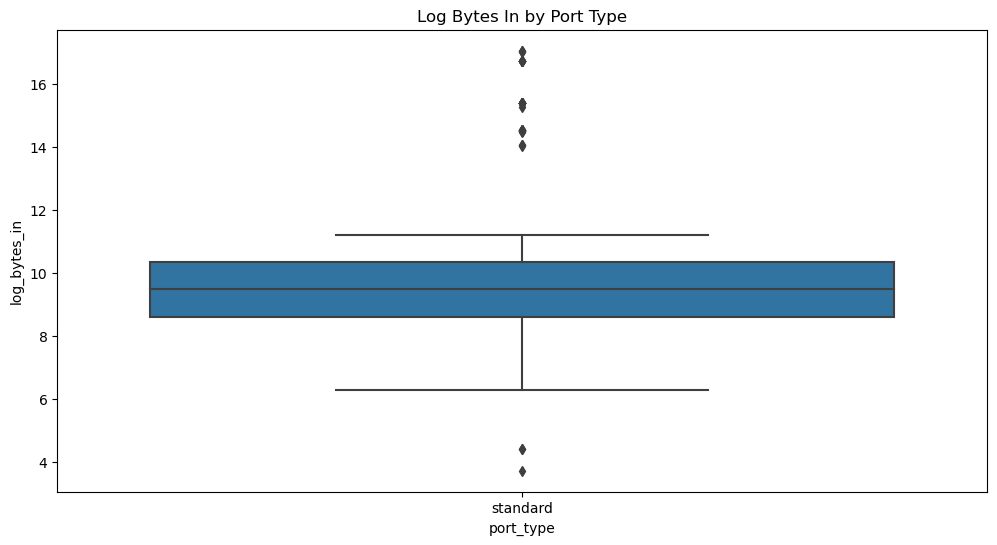

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='port_type', y='log_bytes_in', data=df)
plt.title("Log Bytes In by Port Type")
plt.show()

### Traffic Pattern Over Time

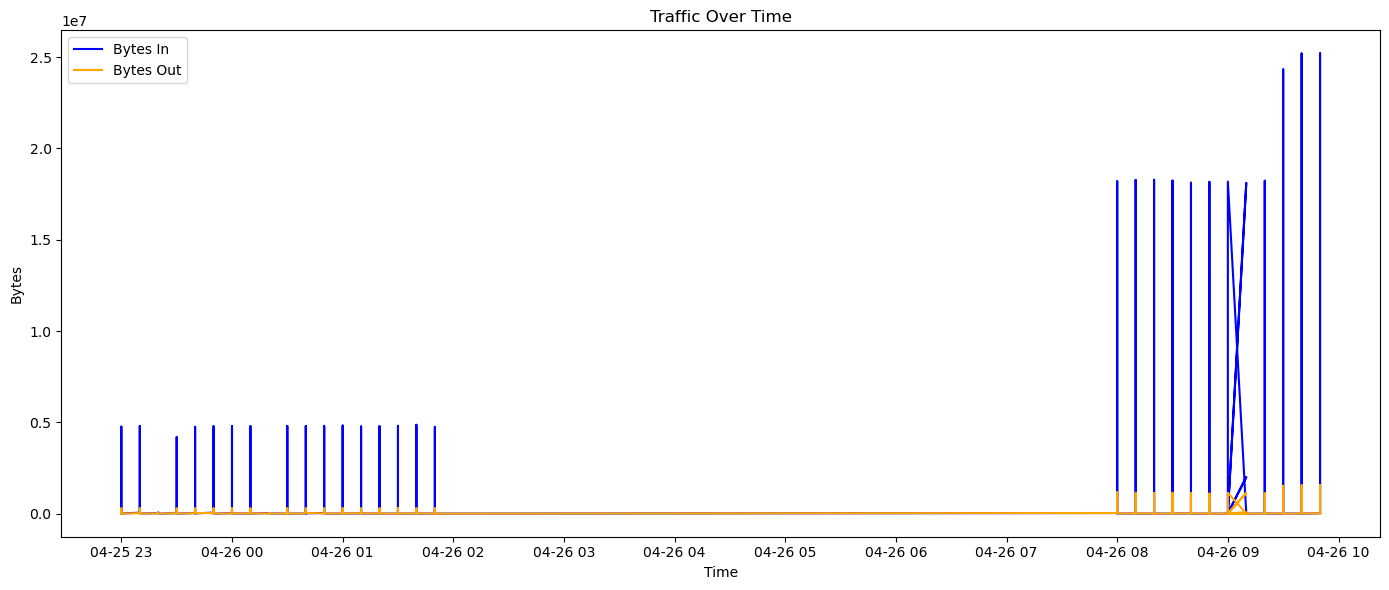

In [69]:
if not df.index.name == 'creation_time':
    df.set_index('creation_time', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['bytes_in'], label='Bytes In', color='blue')
plt.plot(df.index, df['bytes_out'], label='Bytes Out', color='orange')
plt.title("Traffic Over Time")
plt.xlabel("Time")
plt.ylabel("Bytes")
plt.legend()
plt.tight_layout()
plt.show()

### t-SNE for Dimensionality Reduction

In [70]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

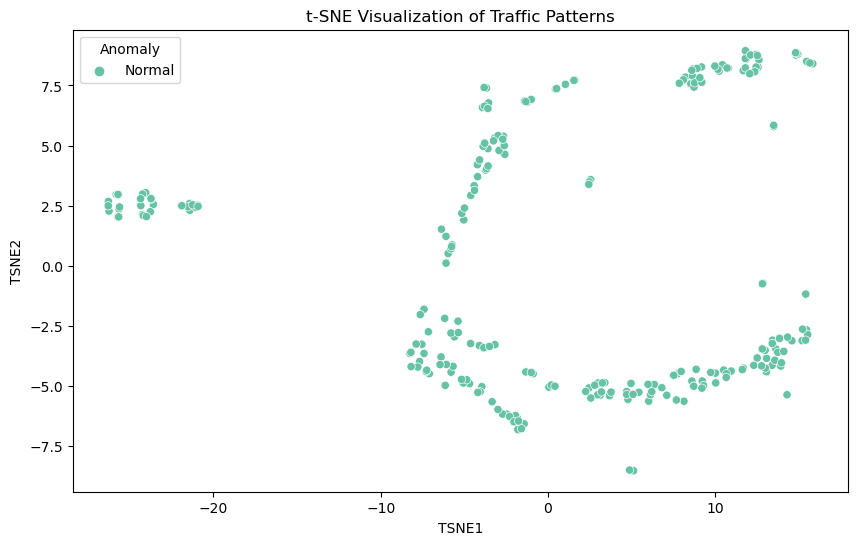

In [73]:
features = df[['log_bytes_in', 'log_bytes_out', 'session_duration_mins']].fillna(0)
features_scaled = StandardScaler().fit_transform(features)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features_scaled)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Anomaly'] = df.get('anomaly_lof', 'Normal')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Anomaly', palette='Set2')
plt.title("t-SNE Visualization of Traffic Patterns")
plt.show()